In [41]:
import copy

import pandas as pd
import sys
import math

sys.path.append('../Coding')
from itertools import combinations
from Algorithms import pattern_count
import time
from Algorithms import NewAlgRanking_19_20211216 as newalg
from Algorithms import NaiveAlgRanking_4_20211213 as naivealg
import numpy as np
import copy
import sys
import math
from sklearn.linear_model import LinearRegression
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

from Algorithms import NewAlgRanking_definition2_13_20220509 as newalg2
from Algorithms import NaiveAlgRanking_definition2_5_20220506 as naivealg2

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

sns.set_palette("Paired")
# sns.set_palette("deep")
sns.set_context("poster", font_scale=2)
sns.set_style("whitegrid")
# sns.palplot(sns.color_palette("deep", 10))
# sns.palplot(sns.color_palette("Paired", 9))

line_style = ['o-', 's--', '^:', '-.p']
color = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']
# plt_title = ["BlueNile", "COMPAS", "Credit Card"]
#
# label = ["PropBounds", "IterTD"]
line_width = 8
marker_size = 15
f_size = (14, 8)

In [42]:
def string2num(st):
    p = list()
    idx = 0
    item = ''
    i = ''
    for i in st:
        if i == '|':
            if item == '':
                p.append(-1)
            else:
                p.append(int(item))
                item = ''
            idx += 1
        else:
            item += i
    if i != '|':
        p.append(int(item))
    else:
        p.append(-1)
    return p


def P1DominatedByP2(P1, P2):
    length = len(P1)
    for i in range(length):
        if P1[i] == -1:
            if P2[i] != -1:
                return False
        if P1[i] != -1:
            if P2[i] != P1[i] and P2[i] != -1:
                return False
    return True

def idx_of_tuples_in_group(group, data):
    def belong_to_group(row):
        nonlocal group
        if P1DominatedByP2(row, group):
            return True
        else:
            return False
    data["in"] = data.apply(belong_to_group, axis=1)
    return data[data["in"] == True].index

def average_shapley_values_of_group(data, group, all_attributes, shap_values, output_file):
    # get all tuples in this group
    data1 = data[all_attributes].copy(deep=True)
    tuples_idx = idx_of_tuples_in_group(group, data1).to_list()
    if len(tuples_idx) == 0:
        output_file.write("\ngroup {} size {}\n".format(group, len(tuples_idx)))
        print("group {} size {}".format(group, len(tuples_idx)))
    else:
        # print(tuples_idx)
        # for id in tuples_idx:
        #     print(id, shap_values.values[id][-1])
        avg = np.average(shap_values.values[tuples_idx], axis=0)
        output_file.write("\ngroup {} size {}\n".format(group, len(tuples_idx)))
        output_file.write(str(avg))
        print("group {} size {}".format(group, len(tuples_idx)))
        print(avg)

def idx_of_tuples_in_group_w_attribute(group, data, att, value):
    def belong_to_group(row):
        nonlocal group
        if P1DominatedByP2(row, group):
            if row[att] == value:
                return True
            else:
                return False
        else:
            return False
    data["in"] = data.apply(belong_to_group, axis=1)
    idx = data[data["in"] == True].index
    data.drop(columns=["in"], axis=1, inplace=True)
    return idx


def shapley_values_att_value_seperated(data, group, all_attributes, shap_values, output_file):
    # get all tuples in this group
    data1 = data[all_attributes].copy(deep=True)
    att_idx = 0
    for att in all_attributes:
        for v in range(int(data1.describe()[att]["min"]), int(data1.describe()[att]["max"]) + 1):
            tuples_idx = idx_of_tuples_in_group_w_attribute(group, data1, att, v).to_list()
            if len(tuples_idx) == 0:
                output_file.write("group {} att {} = {} size {}\n".format(group, att, v, len(tuples_idx)))
                print("group {} att {} = {} size {}".format(group, att, v, len(tuples_idx)))
            else:
                values_of_group = shap_values.values[tuples_idx]
                avg = np.average(values_of_group, axis=0)
                print("group {} att {} = {} size {}\n avg {}".format(group, att, v, len(tuples_idx), avg))
                output_file.write("group {} att {} = {} size {} avg {}\n".format(group, att, v, len(tuples_idx), avg[att_idx]))
        att_idx += 1

def tuples_in_group(g, data, selected_attributes):
    tuple_idx = idx_of_tuples_in_group(g, data[selected_attributes].copy(deep=True))
    tuples = data.iloc[tuple_idx]
    return tuples

def tuples_not_in_group(g, data, selected_attributes):
    tuple_idx = idx_of_tuples_in_group(g, data[selected_attributes].copy(deep=True))
    return data.drop(tuple_idx)

def check_another_group_global_bounds(g, data, selected_attributes, thc, Lowerbounds, k):
    size_whole_data = len(tuples_in_group(g, data, selected_attributes))
    if size_whole_data < thc:
        print("group g size too small", size_whole_data)
        return False
    size_topk = len(tuples_in_group(g, data[:k], selected_attributes))
    if size_topk < Lowerbounds[0]:
        print("group g doesn't have enough representation in top k", size_topk)
        return False
    return True


def check_another_group_prop_bounds(g, data, selected_attributes, thc, alpha, k):
    size_whole_data = len(tuples_in_group(g, data, selected_attributes))
    if size_whole_data < thc:
        print("group g size too small", size_whole_data)
        return False
    size_topk = len(tuples_in_group(g, data[:k], selected_attributes))
    lowerbound = alpha * size_whole_data * k / len(data)
    print(size_whole_data, size_topk, lowerbound)
    if size_topk < lowerbound:
        print("group g doesn't have enough representation in top k", size_topk)
        return False
    return True

def plot_distribution_number(ranked_data, attribute, group, another_group, k):
    x_list = ranked_data[attribute].unique()
    x_list.sort()
    tuples = tuples_in_group(group, ranked_data, selected_attributes)
    s = tuples[attribute].value_counts().sort_index()
    group_value_dis = [s[i] if i in s else 0 for i in x_list]
    s = ranked_data[attribute].value_counts().sort_index()
    whole_data_dis = [s[i] if i in s else 0 for i in x_list]
    s = tuples_not_in_group(group, ranked_data, selected_attributes)[attribute].value_counts().sort_index()
    other_data_dis = [s[i] if i in s else 0 for i in x_list]
    s = tuples_in_group(another_group, ranked_data, selected_attributes)[attribute].value_counts().sort_index()
    total = sum(s)
    another_group_dis = [s[i] if i in s else 0 for i in x_list]


    s = ranked_data[:k][attribute].value_counts().sort_index()
    topkdis = [s[i] if i in s else 0 for i in x_list]

    index = np.arange(len(x_list))
    bar_width = 0.2

    fig, ax = plt.subplots(1, 1, figsize=(20, 8))

    index = np.arange(len(x_list))
    plt.bar(index, group_value_dis, bar_width, color=color[0], label="group")
    plt.bar(index + bar_width, whole_data_dis, bar_width,  color=color[2], label="whole data")
    plt.bar(index + bar_width * 2, other_data_dis, bar_width,  color=color[4], label="other data")
    plt.bar(index + bar_width * 3, another_group_dis, bar_width,  color=color[6], label="non-problematic group")
    plt.bar(index + bar_width * 4, topkdis, bar_width,  color=color[8], label="topk")
    # plt.xticks(index + bar_width, x_list)
    # plt.xticks(index, x_list)

    plt.ylabel('number of tuples')
    plt.xlabel('value of attribute ' + attribute)
    # plt.yscale('log')
    plt.legend(loc='best', fontsize=25)

    plt.tight_layout()
    # plt.savefig("adult_time.png", bbox_inches='tight')
    plt.show()

def plot_distribution_ratio(ranked_data, attribute, group, another_group, k):
    x_list = ranked_data[attribute].unique()
    x_list.sort()
    tuples = tuples_in_group(group, ranked_data, selected_attributes)
    s = tuples[attribute].value_counts().sort_index()
    total = sum(s)
    group_value_dis = [s[i]/total if i in s else 0 for i in x_list]
    s = ranked_data[attribute].value_counts().sort_index()
    total = sum(s)
    whole_data_dis = [s[i]/total if i in s else 0 for i in x_list]
    s = tuples_not_in_group(group, ranked_data, selected_attributes)[attribute].value_counts().sort_index()
    total = sum(s)
    other_data_dis = [s[i]/total if i in s else 0 for i in x_list]
    s = tuples_in_group(another_group, ranked_data, selected_attributes)[attribute].value_counts().sort_index()
    total = sum(s)
    another_group_dis = [s[i]/total if i in s else 0 for i in x_list]
    bar_width = 0.20

    s = ranked_data[:k][attribute].value_counts().sort_index()
    total = sum(s)
    topkdis = [s[i]/total if i in s else 0 for i in x_list]
    fig, ax = plt.subplots(1, 1, figsize=(20, 8))

    index = np.arange(len(x_list))
    plt.bar(index, group_value_dis, bar_width, color=color[0], label="group")
    plt.bar(index + bar_width, whole_data_dis, bar_width,  color=color[2], label="whole data")
    plt.bar(index + bar_width * 2, other_data_dis, bar_width,  color=color[4], label="other data")
    plt.bar(index + bar_width * 3, another_group_dis, bar_width,  color=color[6], label="non-problematic group")
    plt.bar(index + bar_width * 4, topkdis, bar_width,  color=color[8], label="topk")
    # plt.xticks(index + bar_width, x_list)
    print(x_list)
    # plt.xticks(range(x_list[0], x_list[-1]+1))
    plt.xticks(index, x_list)
    plt.ylabel('ratio')
    plt.xlabel('value of attribute '+attribute)
    # plt.yscale('log')
    plt.legend(loc='best', fontsize=25)

    plt.tight_layout()
    # plt.savefig("adult_time.png", bbox_inches='tight')
    plt.show()



# compas

In [43]:

all_attributes = ["age_binary", "sex_binary", "race_C",
                  "MarriageStatus_C", "juv_fel_count_C", "decile_score_C",
                  "juv_misd_count_C", "juv_other_count_C", "priors_count_C",
                  "days_b_screening_arrest_C", "c_days_from_compas_C", "c_charge_degree_C",
                  "v_decile_score_C", "start_C", "end_C", "event_C"]

original_data_file = r"../../../InputData/CompasData/general/compas_data_cat_necessary_att_ranked.csv"

ranked_data = pd.read_csv(original_data_file, index_col=False)

# scoring attributes:
# c days from compas,
# juv other count, days b screening arrest, start, end,
# age, and priors count


In [44]:
selected_attributes = all_attributes[:14]

k = 50
k_min = k
k_max = k
thc = 50
Lowerbounds = [20]
time_limit = 5*60
result_global_bounds, num_patterns_visited1_, t1_ \
    = newalg.GraphTraverse(
    ranked_data[selected_attributes].copy(deep=True), selected_attributes, thc,
    Lowerbounds,
    k_min, k_max, time_limit)
groups_global_bounds = result_global_bounds[0]
for g in groups_global_bounds:
    print(g)


[1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, 4, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, 6, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, 2, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, 2, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1]
[0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1]
[-1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1]
[-1, -1, 0, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, 0, -1, -1, -1, -1, -1, -1, 0, -1, -1, -1, 

In [45]:
selected_attributes = all_attributes[:14]

alpha = 0.8
k = 10
k_min = k
k_max = k
thc = 50
time_limit = 5*60
result_prop_bounds, num_patterns_visited1_, t1_ \
            = newalg2.GraphTraverse(
            ranked_data[selected_attributes], selected_attributes, thc,
            alpha,
            k_min, k_max, time_limit)
groups_prop_bounds = [string2num(k) for k in result_prop_bounds[0]]
for g in groups_prop_bounds:
    print(g)


time for k_min = 13.730942964553833
finish kmin
[1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, 0, 6, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, 2, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1]
[-1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1]
[-1, -1, -1, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, 4, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, 2, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1]
[-1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1]


In [46]:

x = ranked_data[selected_attributes]
y = ranked_data['rank']

# with sklearn
model = LinearRegression()
model.fit(x, y)
print("Model coefficients:\n")
for i in range(x.shape[1]):
    print(x.columns[i], "=", model.coef_[i].round(5))
# compute the SHAP values for the linear model
explainer = shap.Explainer(model.predict, x)
shap_values = explainer(x)
shap_values


Model coefficients:

age_binary = 520.45601
sex_binary = 175.30554
race_C = 32.72339
MarriageStatus_C = -12.64531
juv_fel_count_C = -120.79306
decile_score_C = -454.80896
juv_misd_count_C = 719.00394
juv_other_count_C = 1780.24711
priors_count_C = 770.61898
days_b_screening_arrest_C = 815.08678
c_days_from_compas_C = 1070.39246
c_charge_degree_C = 284.00777
v_decile_score_C = -177.10045
start_C = 2439.799


Permutation explainer: 6890it [01:54, 56.39it/s]                          


.values =
array([[-114.50032234,  -28.04888693,   14.72552624, ..., -107.92295172,
          47.8171223 ,    0.        ],
       [-114.50032234,  -28.04888693,  -17.99786541, ...,  176.08481597,
          47.8171223 ,    0.        ],
       [-114.50032234,  -28.04888693,  -17.99786541, ..., -107.92295172,
          47.8171223 ,    0.        ],
       ...,
       [-114.50032234,  147.2566564 ,  -17.99786541, ..., -107.92295172,
          47.8171223 ,    0.        ],
       [-114.50032234,  -28.04888693,  -17.99786541, ..., -107.92295172,
        -129.28333066,    0.        ],
       [-114.50032234,  -28.04888693,  -17.99786541, ..., -107.92295172,
          47.8171223 ,    0.        ]])

.base_values =
array([3317.15739954, 3317.15739954, 3317.15739954, ..., 3317.15739954,
       3317.15739954, 3317.15739954])

.data =
array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]

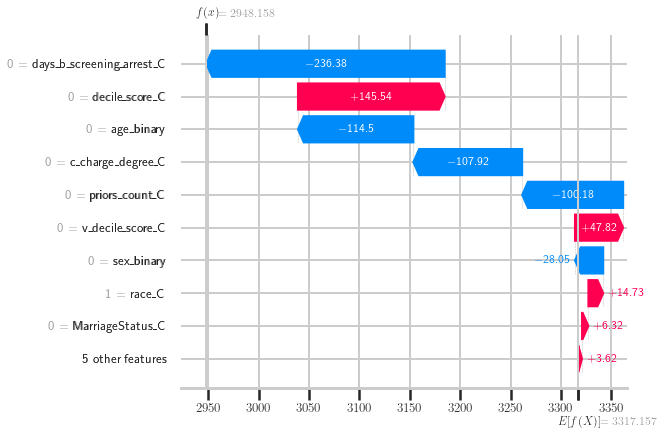

In [47]:
shap.plots.waterfall(shap_values[0])

group g doesn't have enough representation in top k 7
False
[0 1]


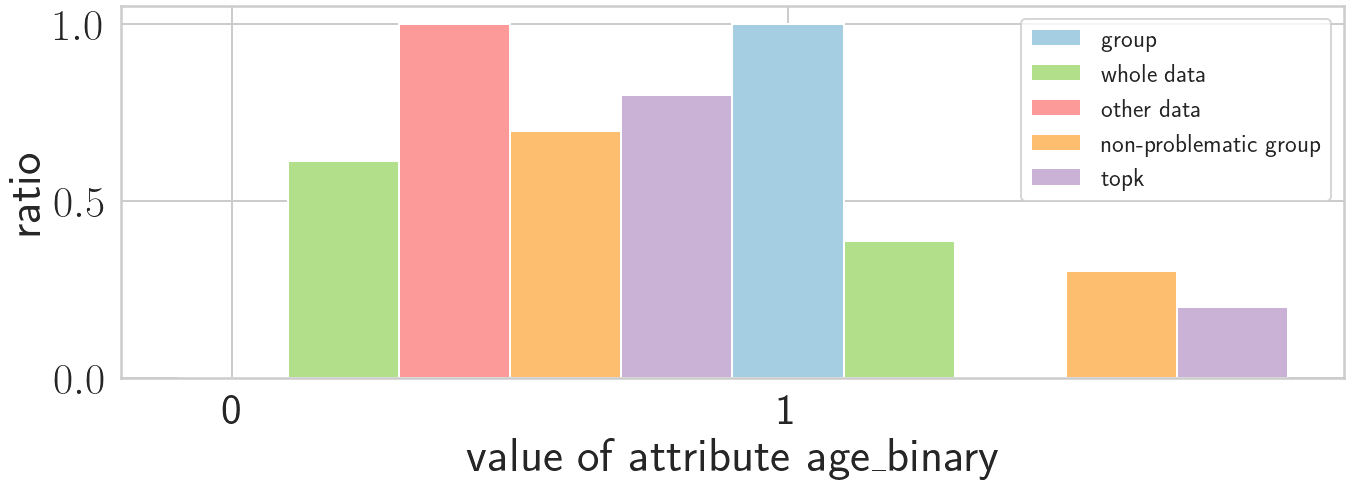

[0 1]


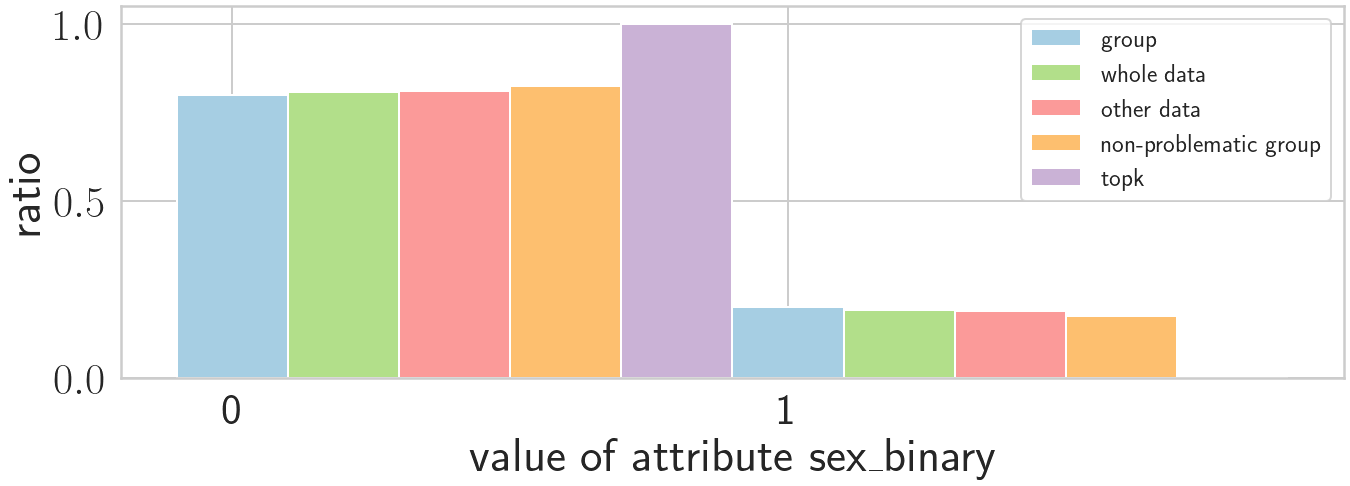

[0 1 2]


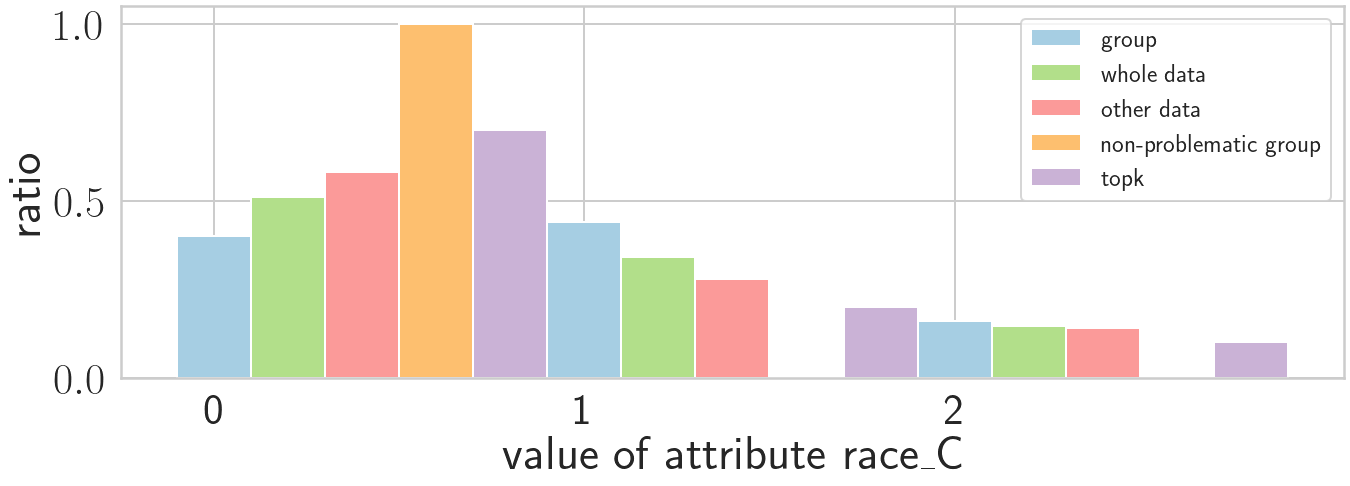

[0 1 2 3 4 5 6]


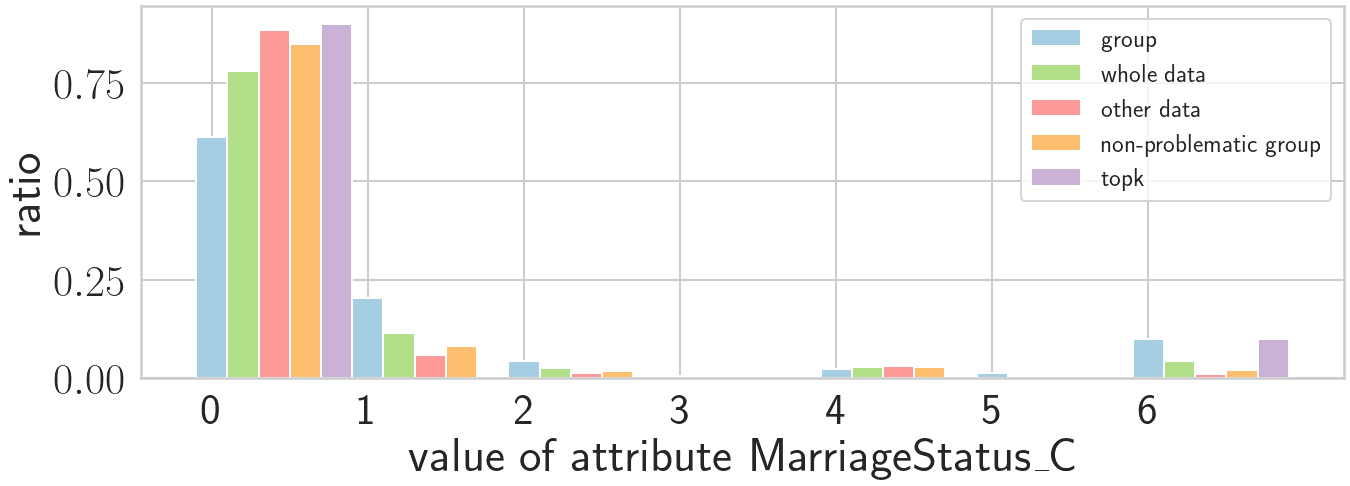

[0 1 2 3]


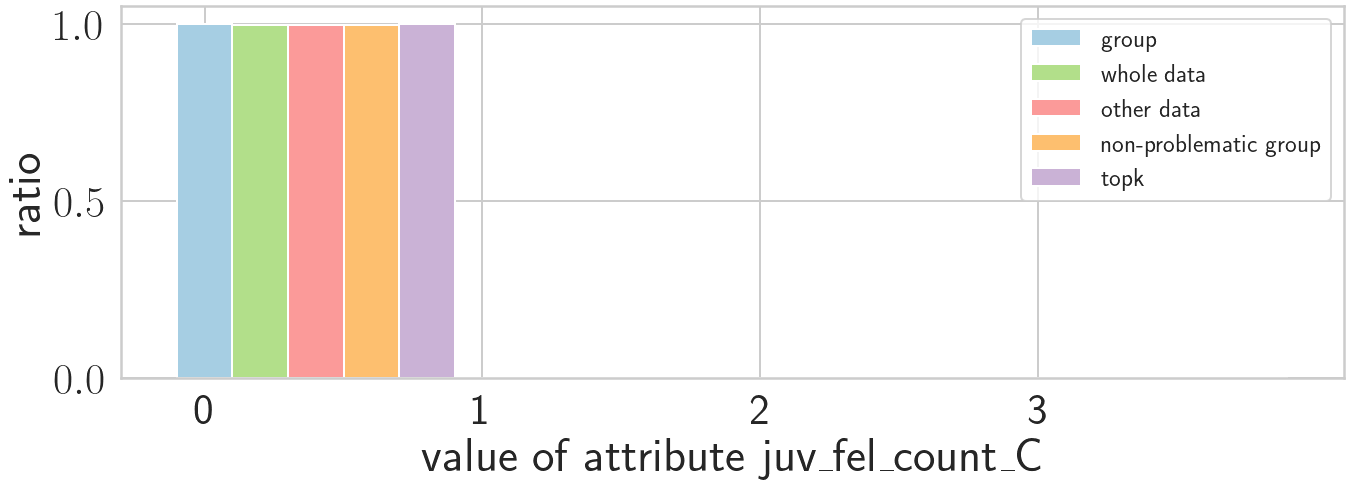

[0 1]


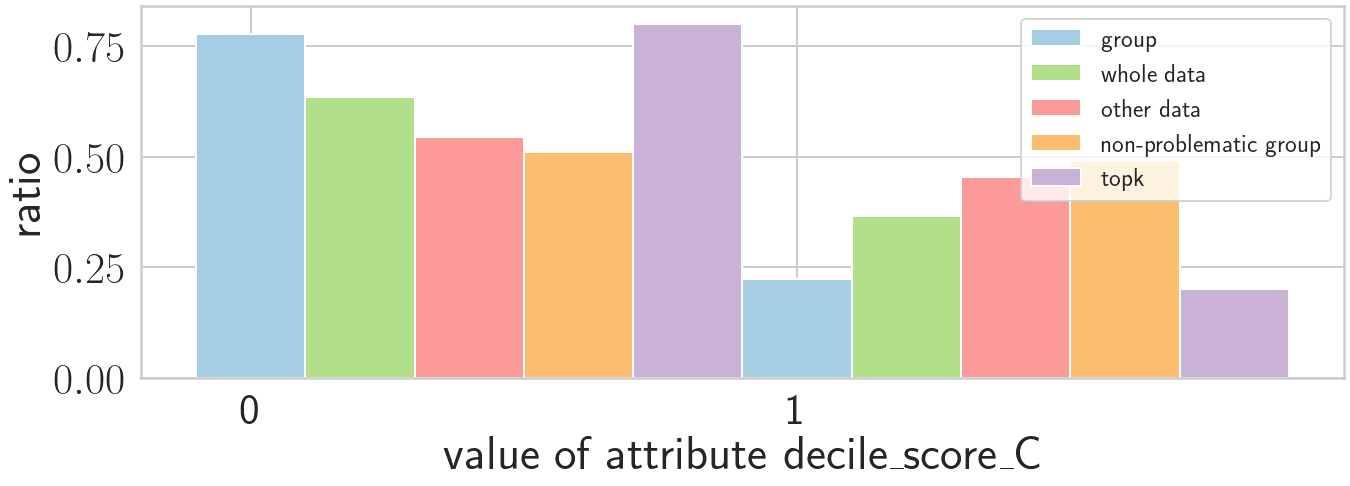

[0 1 2]


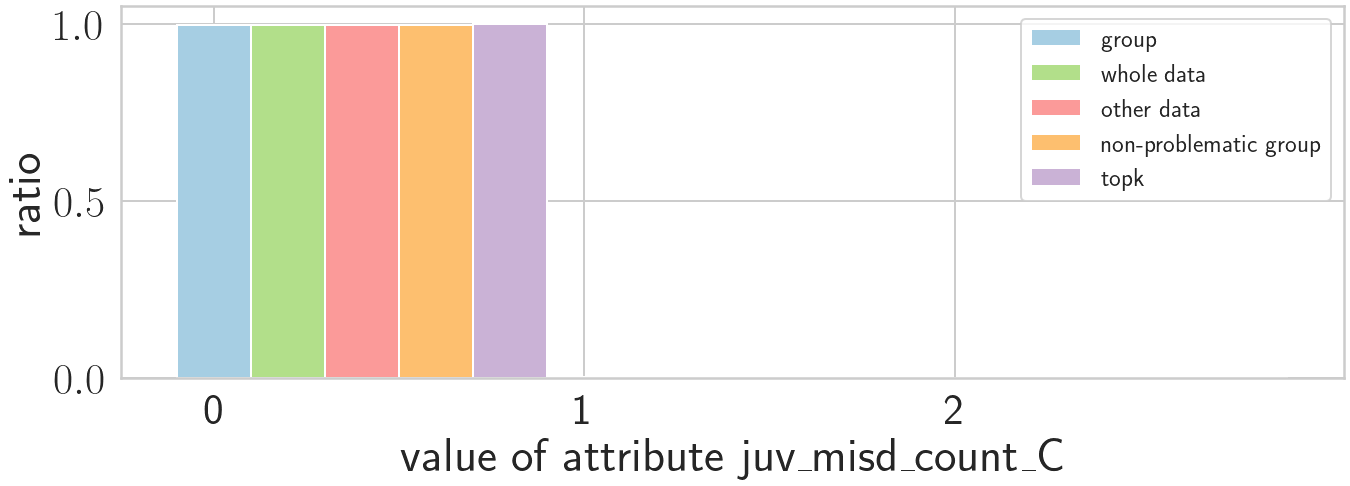

[0 1 2]


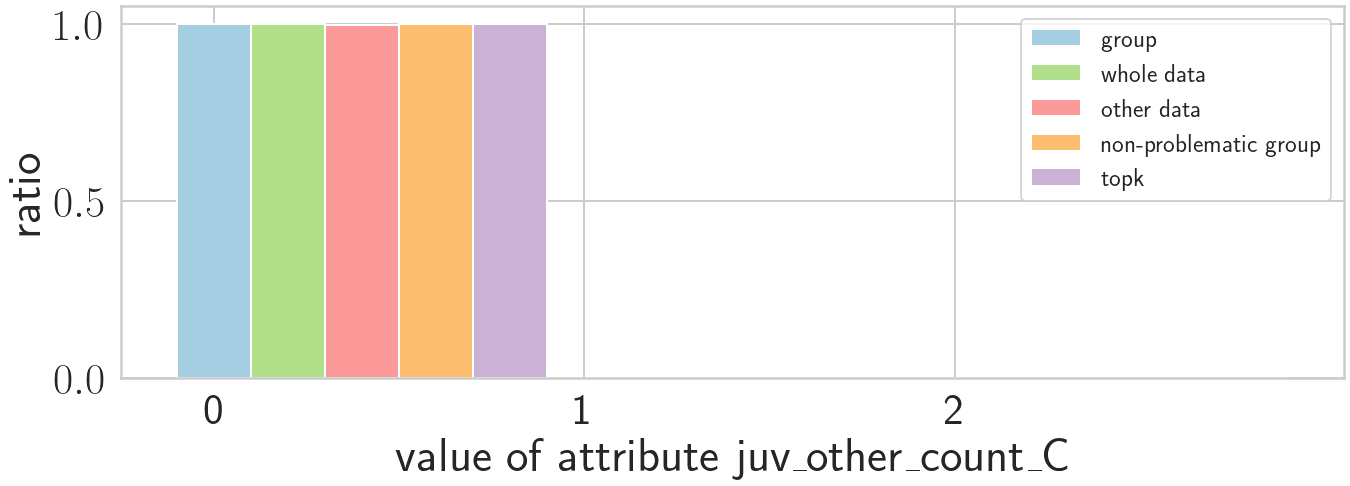

[0 1 2 3]


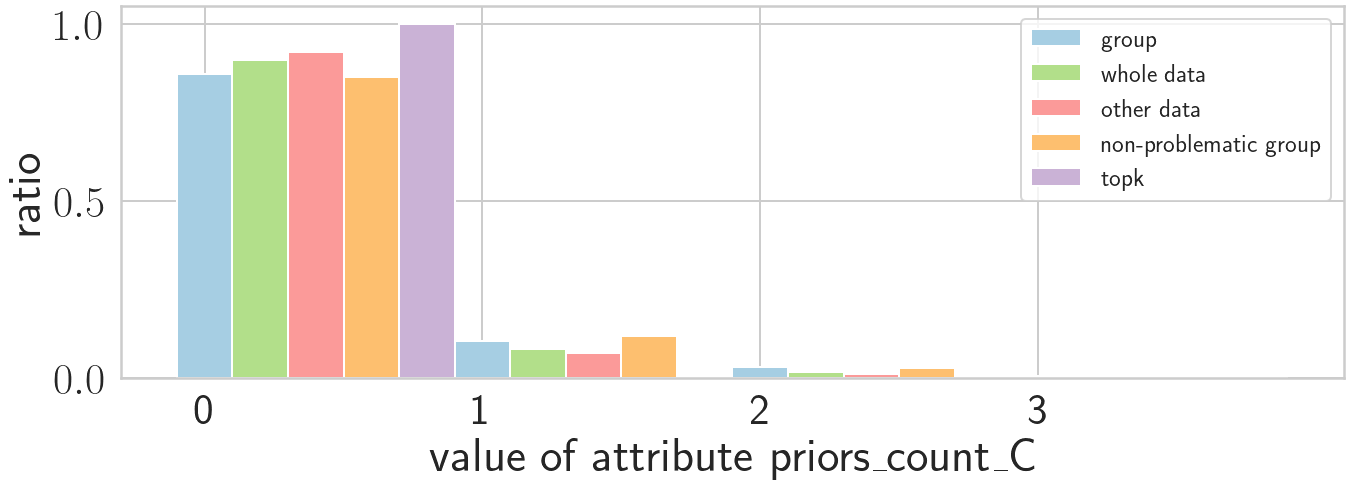

[0 1 2]


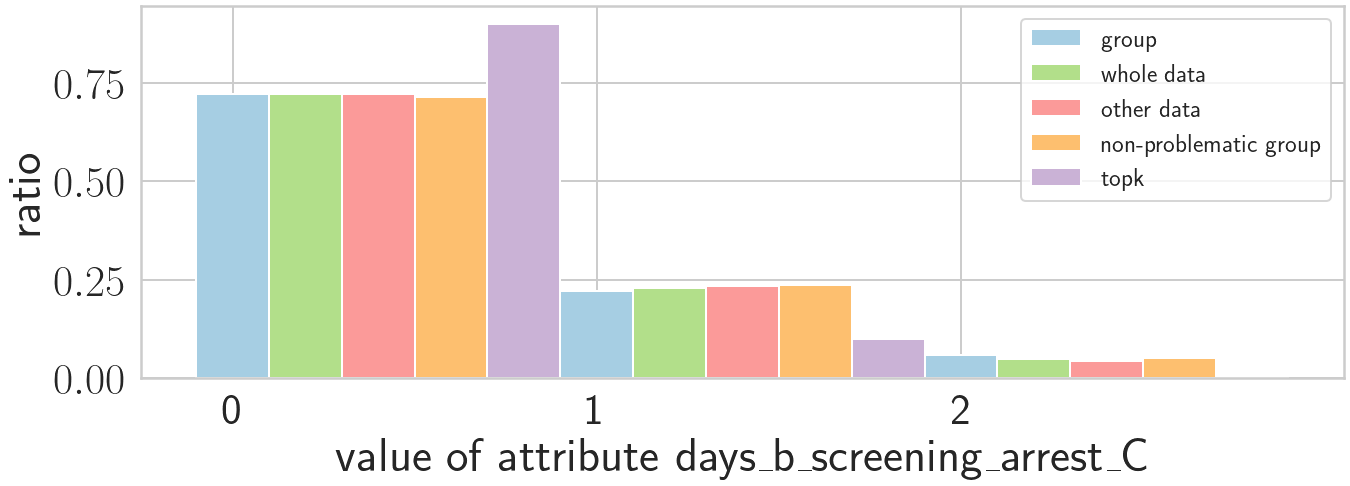

[0 1 2]


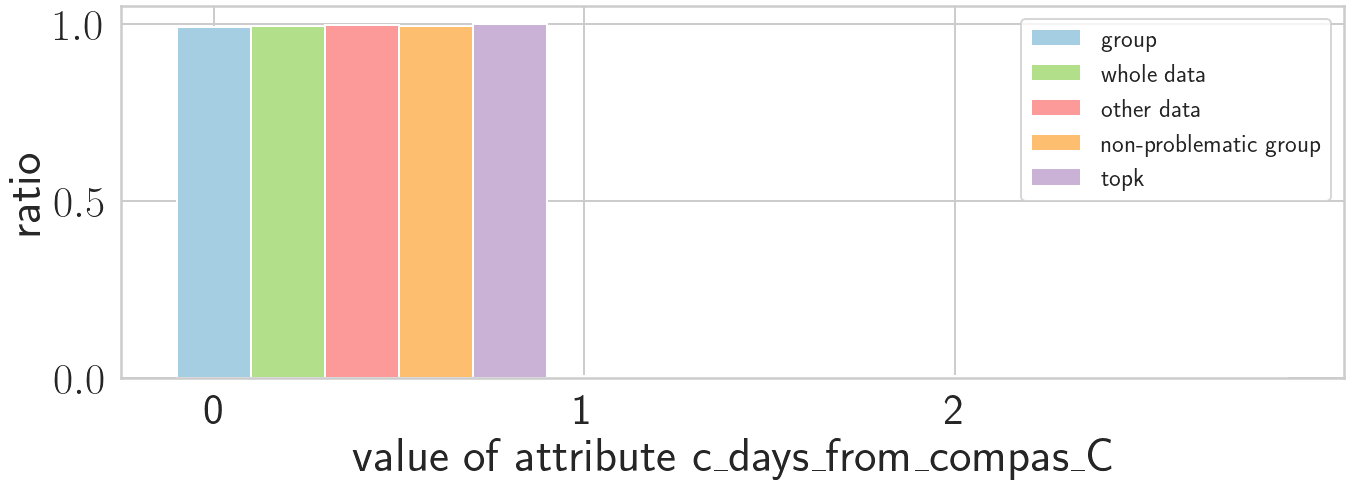

[0 1]


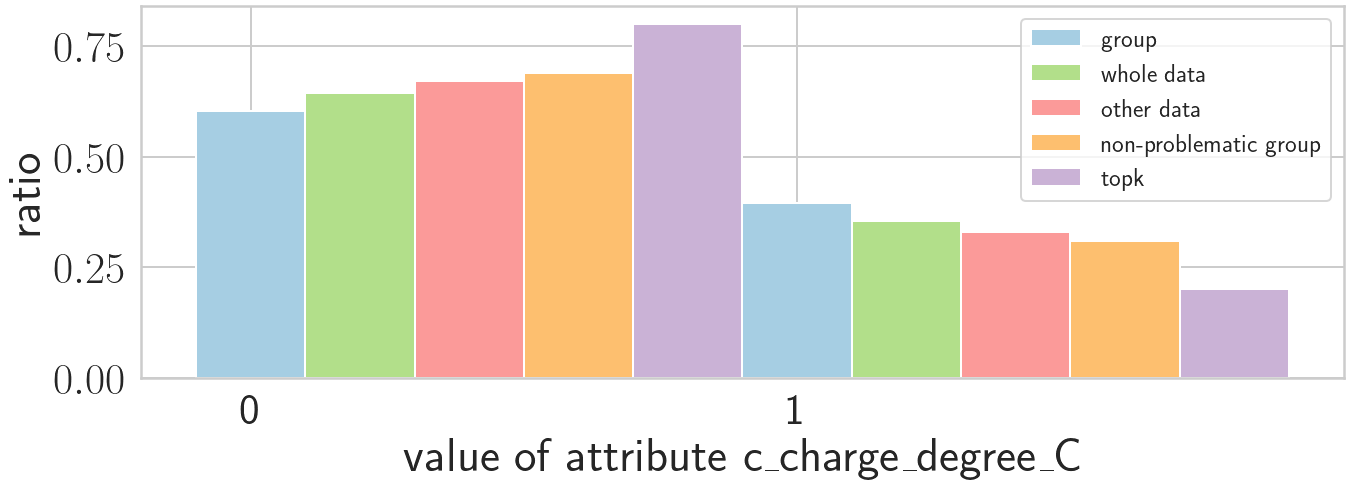

[0 1]


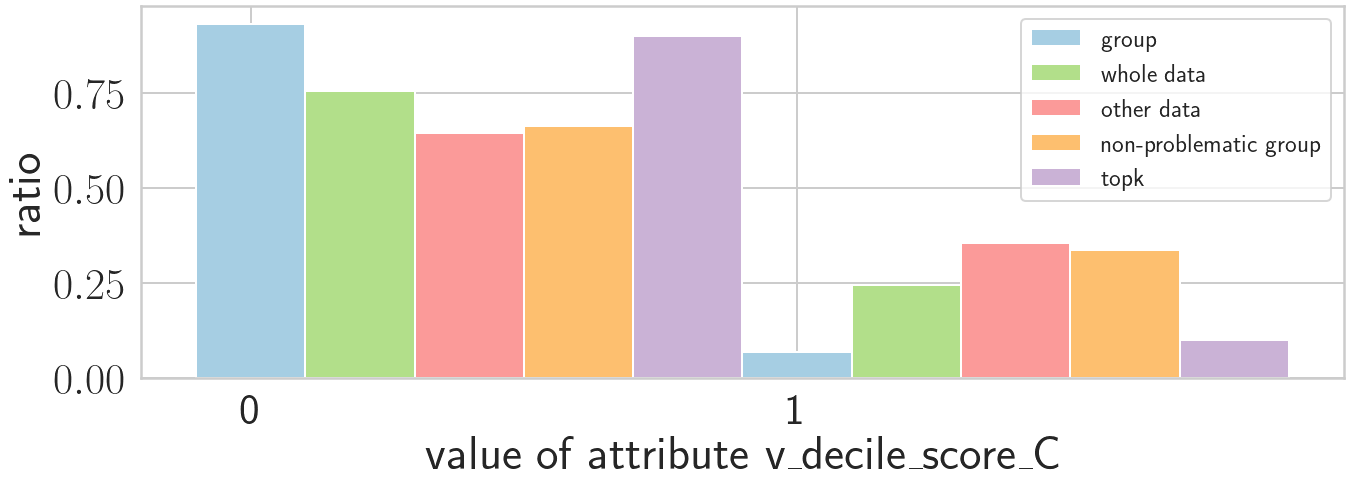

[0 1 2]


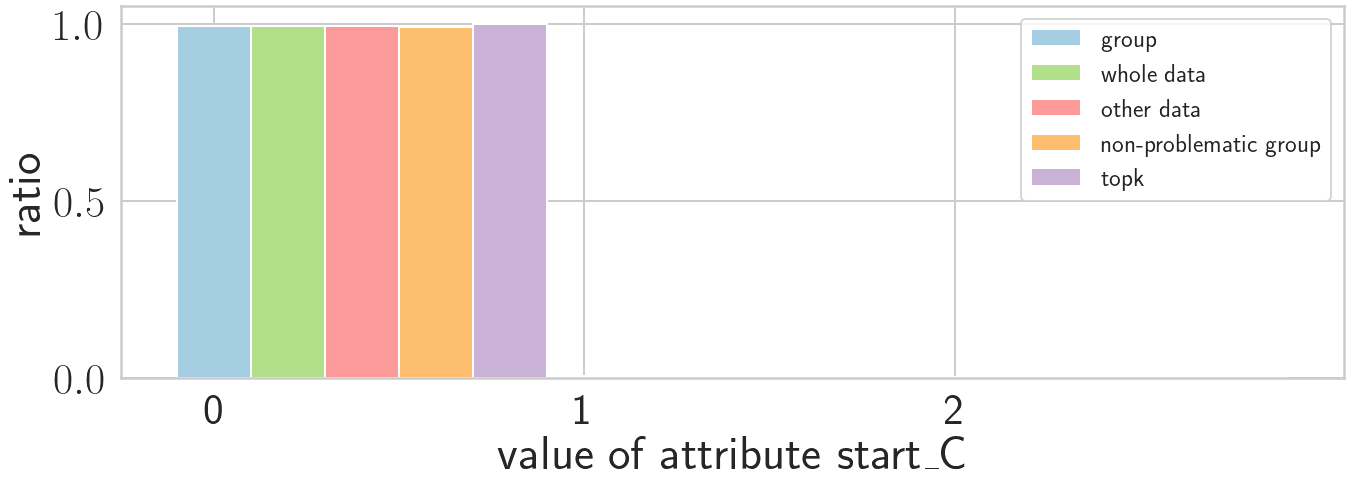

KeyError: 'end_C'

In [51]:
another_group = [-1, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
print(check_another_group_global_bounds(another_group, ranked_data, selected_attributes, thc, Lowerbounds, k))
for att in all_attributes:
    plot_distribution_ratio(ranked_data[selected_attributes], att, groups_global_bounds[0], another_group, k)


5561 10 6.457831325301205
True
[0 1]


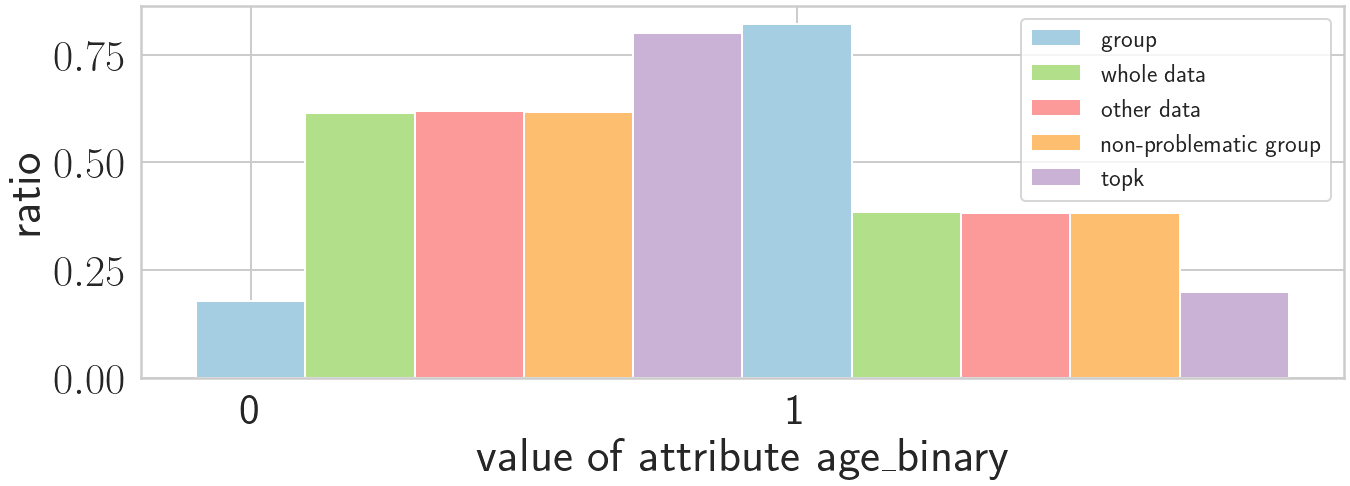

[0 1]


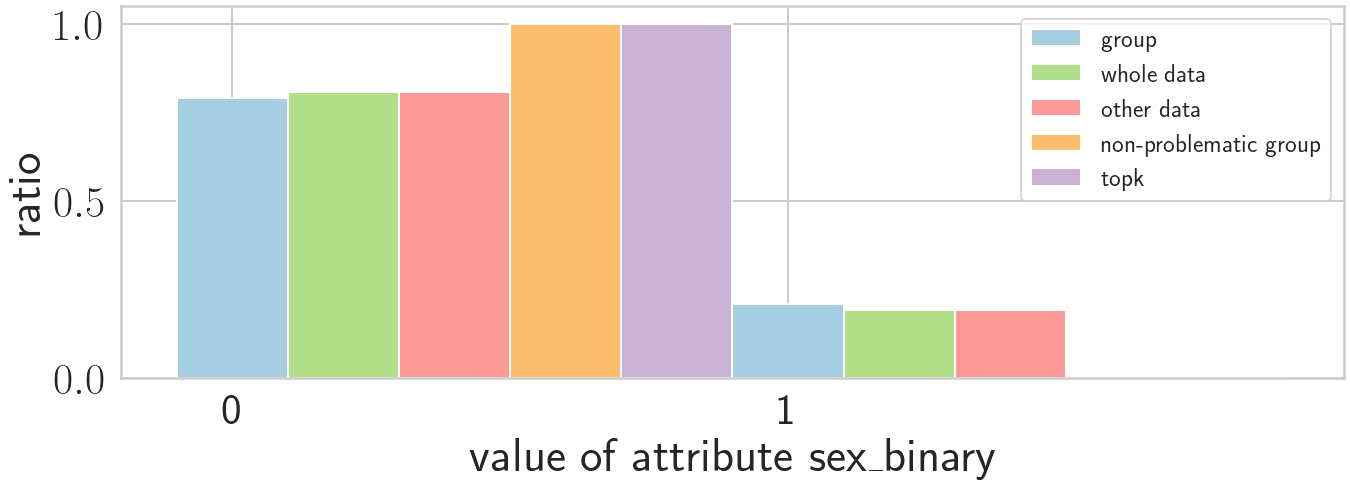

[0 1 2]


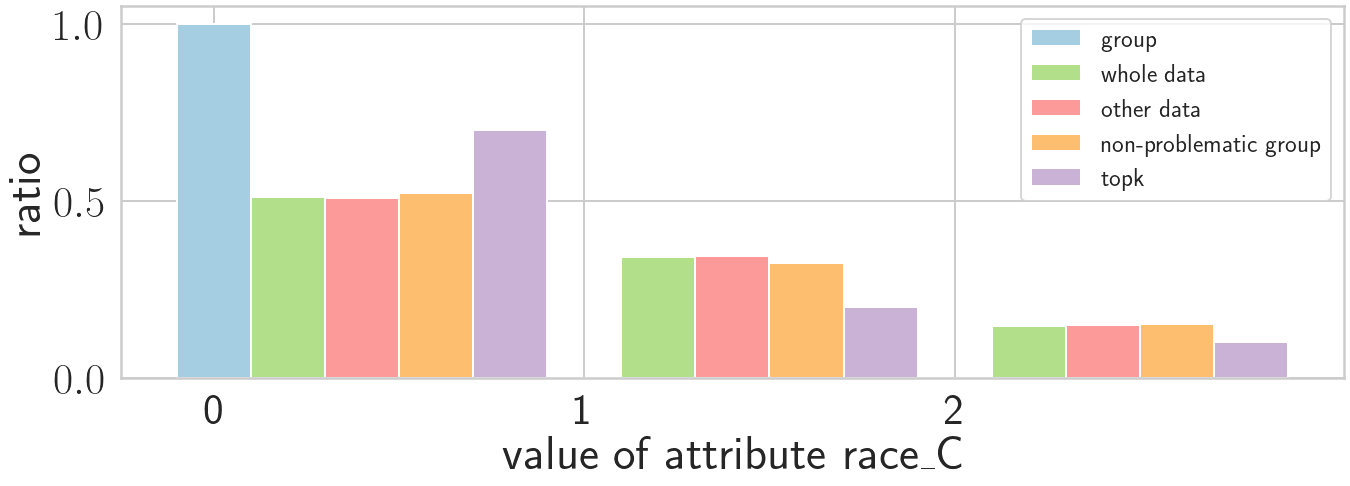

[0 1 2 3 4 5 6]


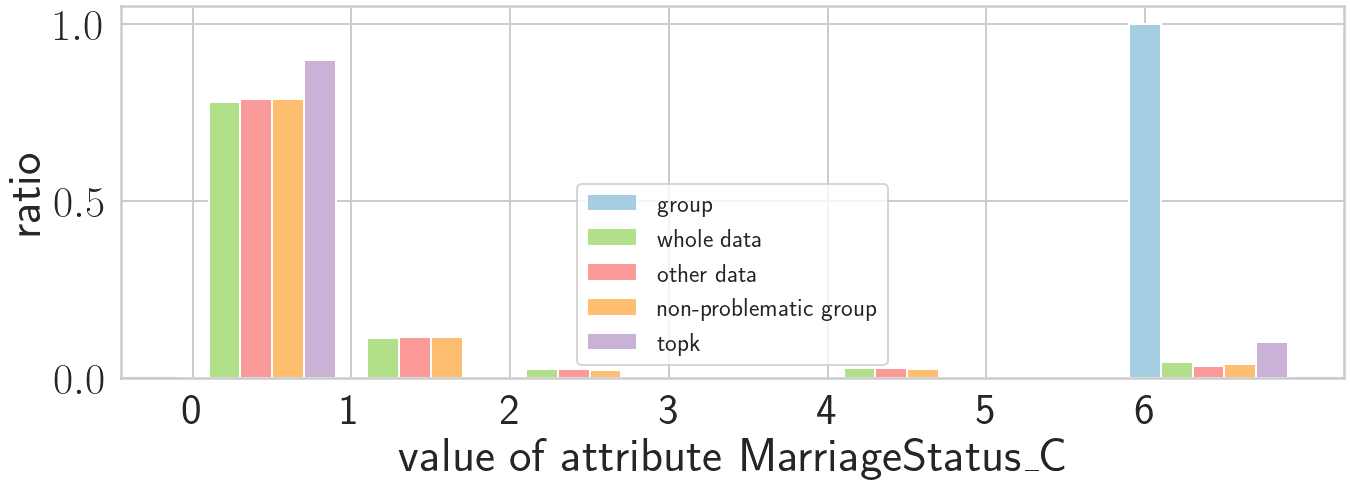

[0 1 2 3]


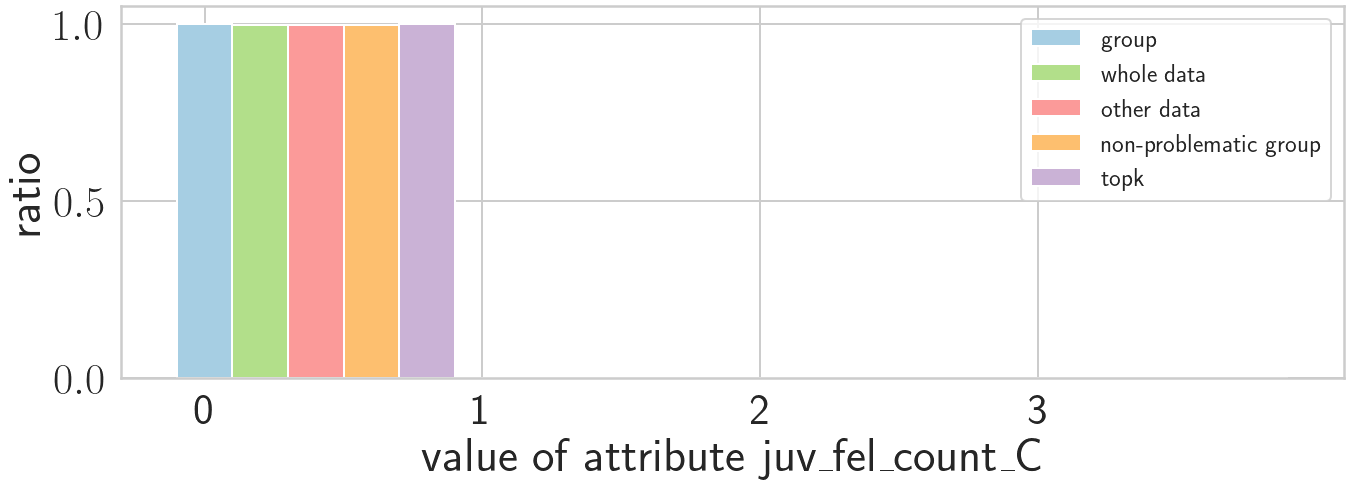

[0 1]


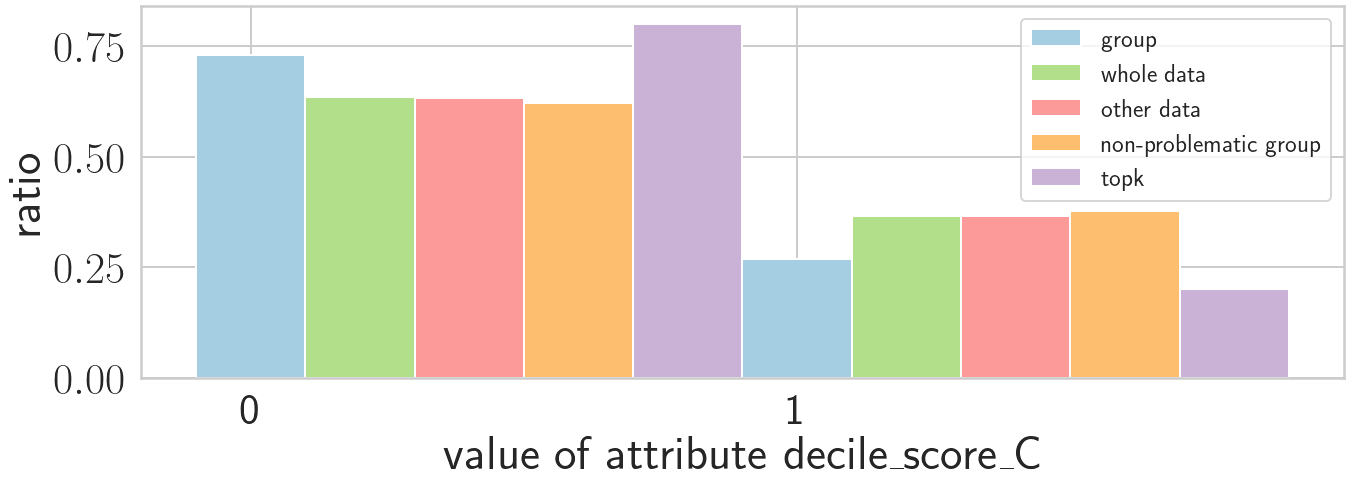

[0 1 2]


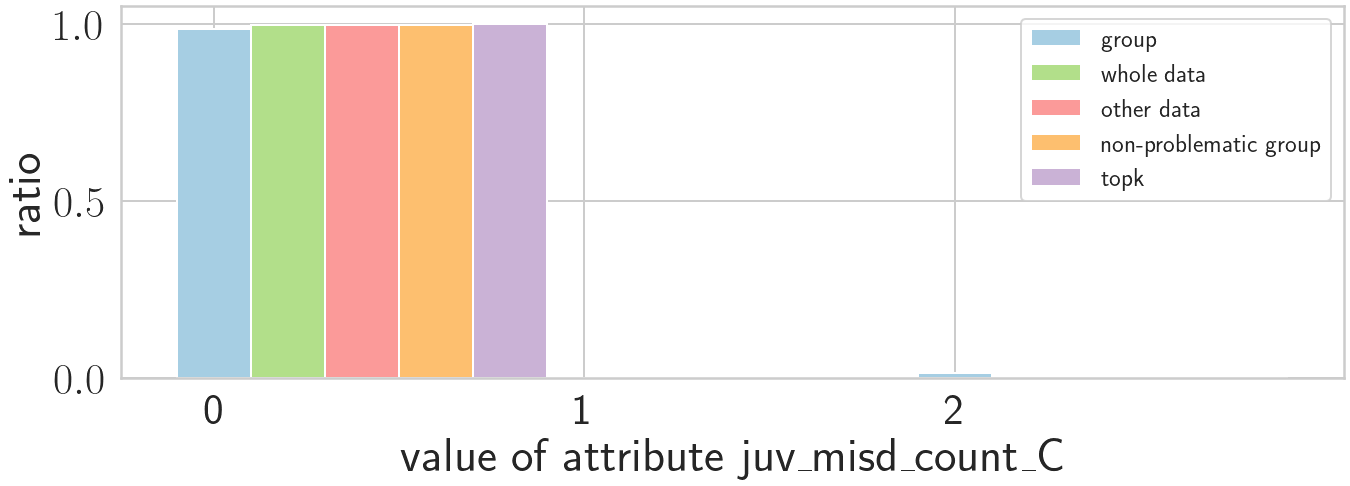

[0 1 2]


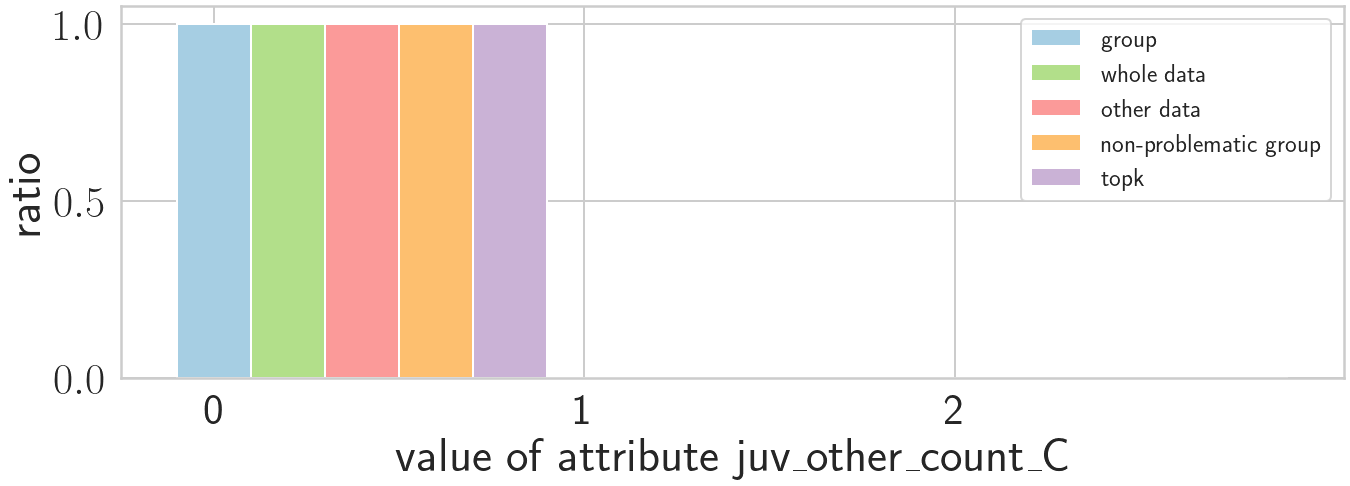

[0 1 2 3]


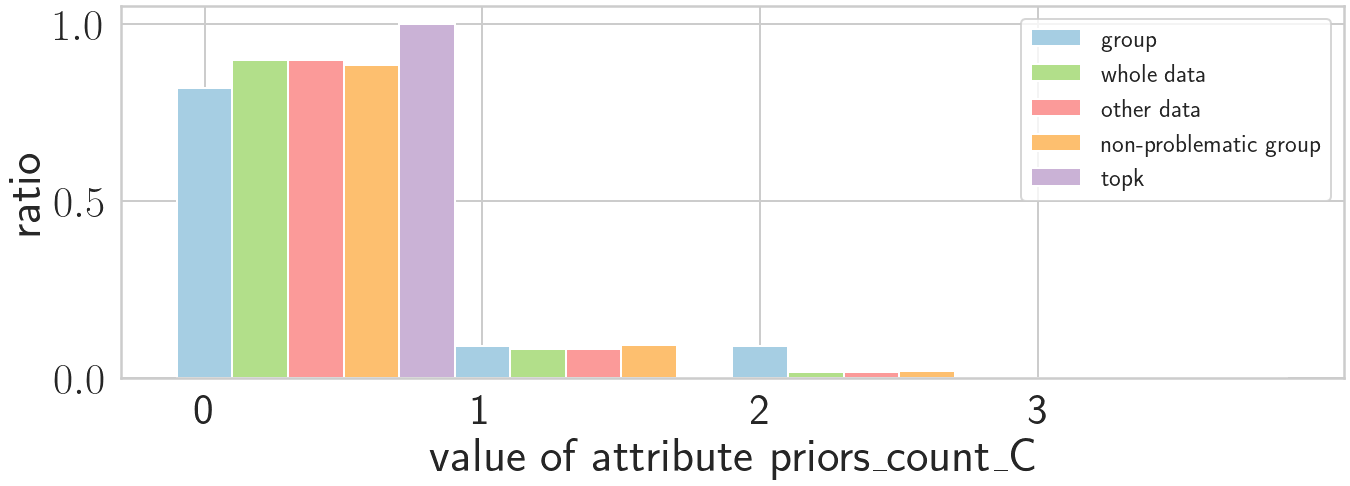

[0 1 2]


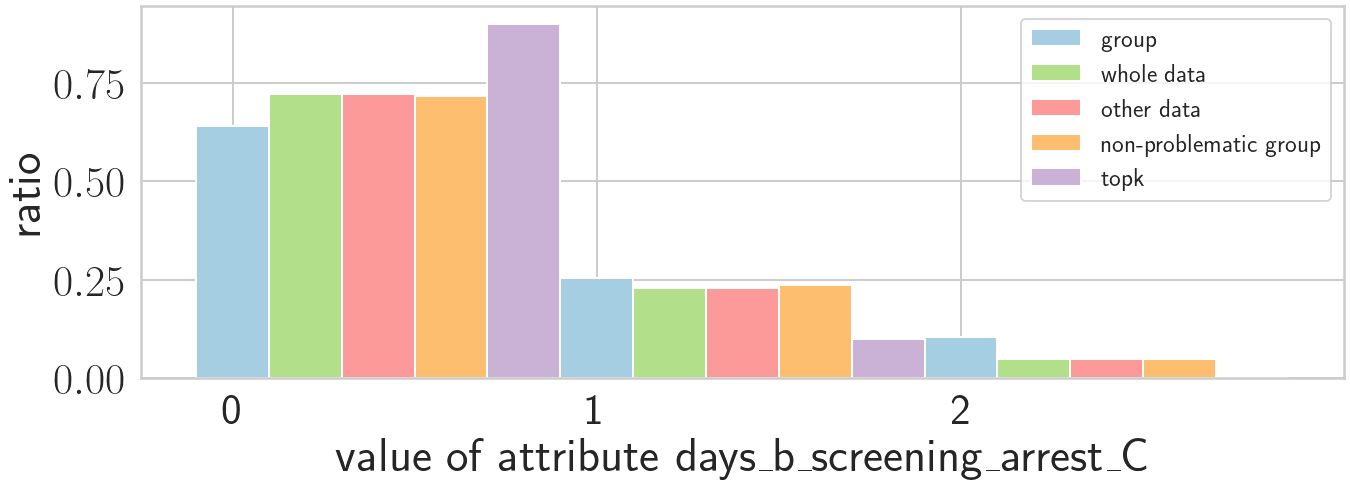

[0 1 2]


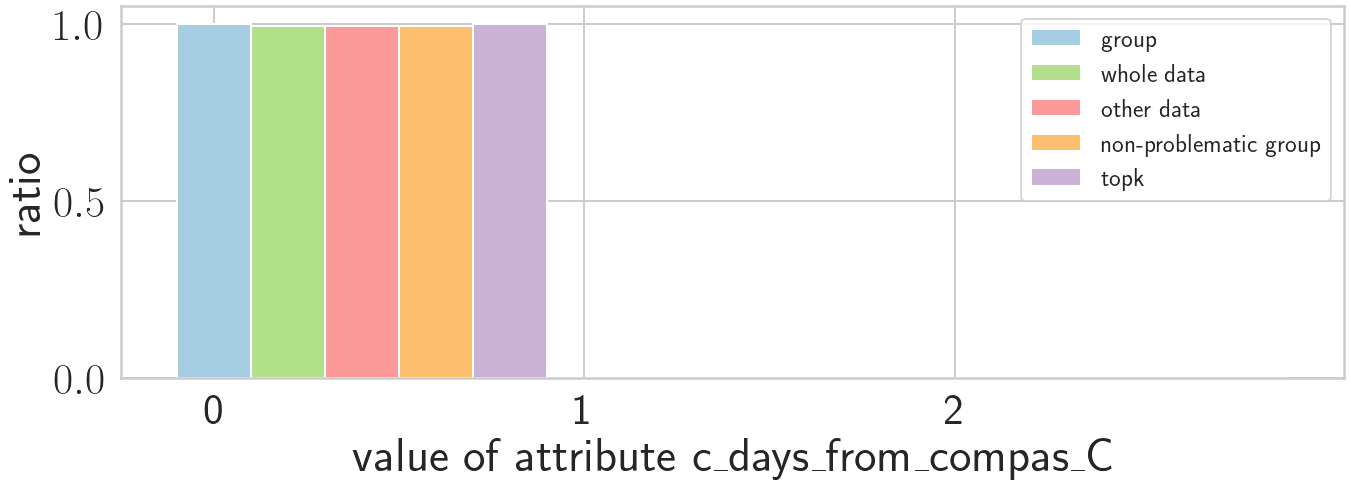

[0 1]


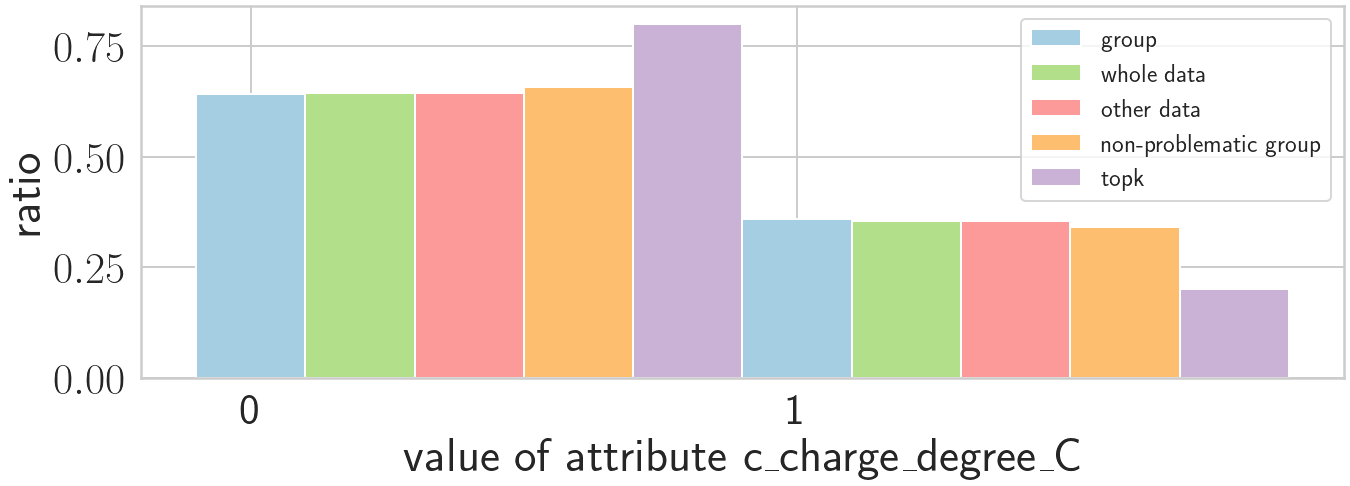

[0 1]


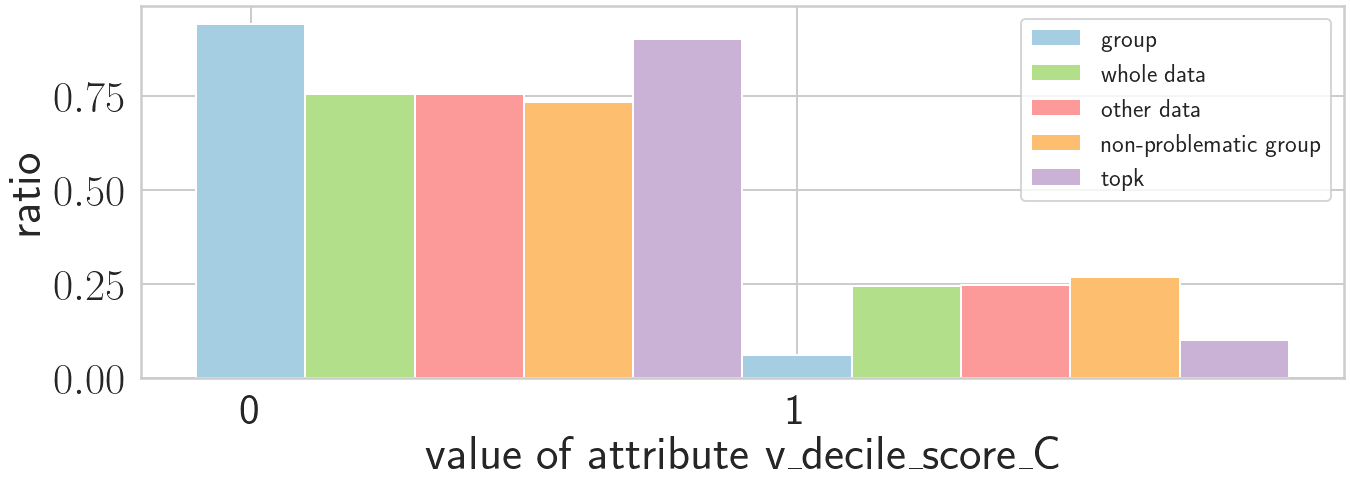

[0 1 2]


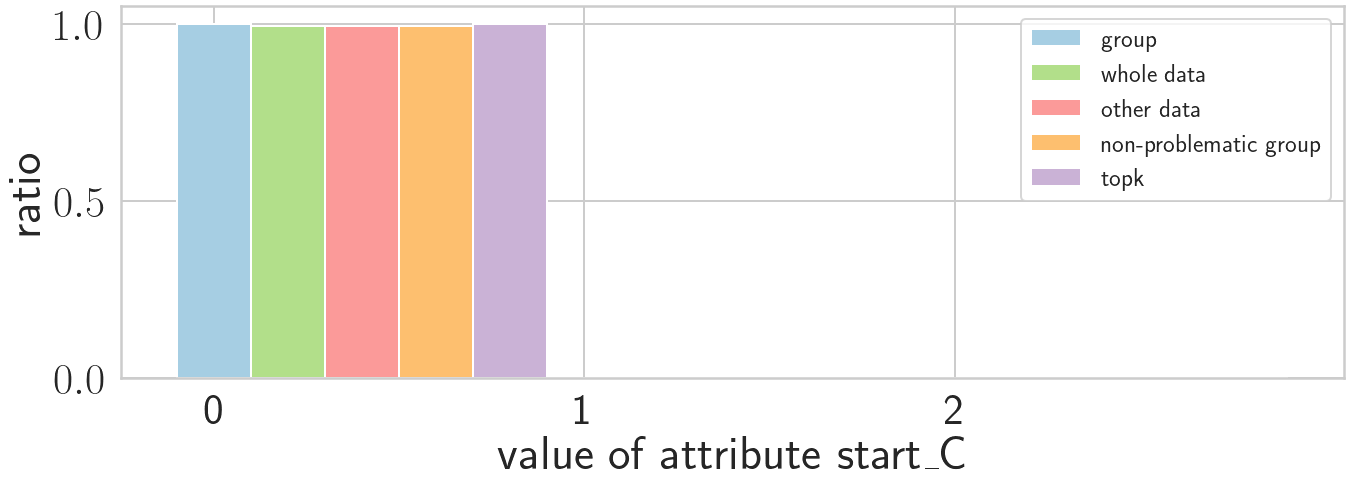

[0 1 2]


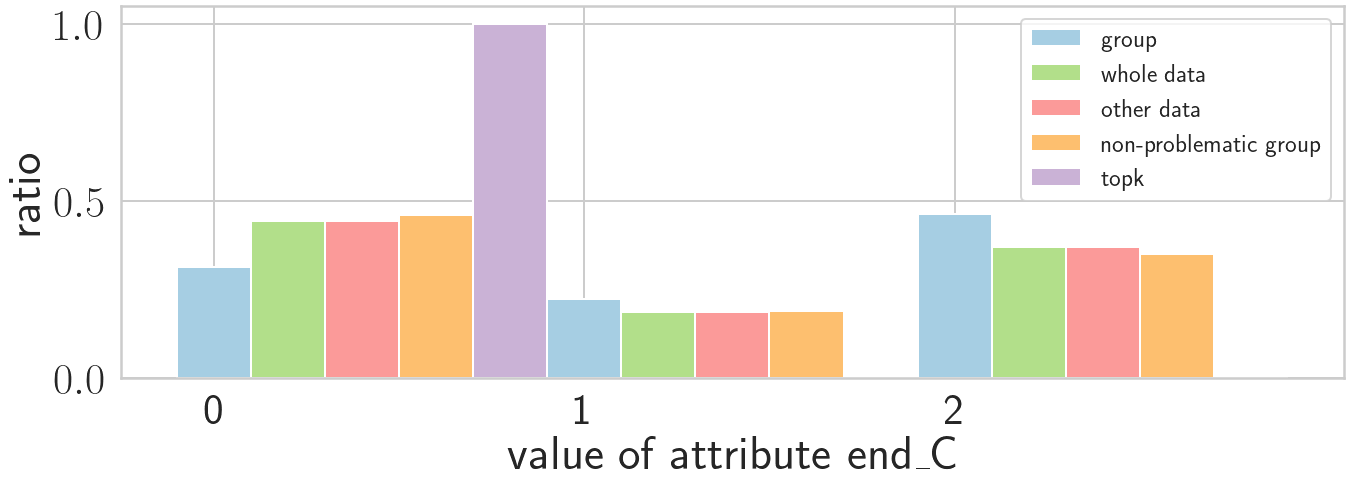

[0 1]


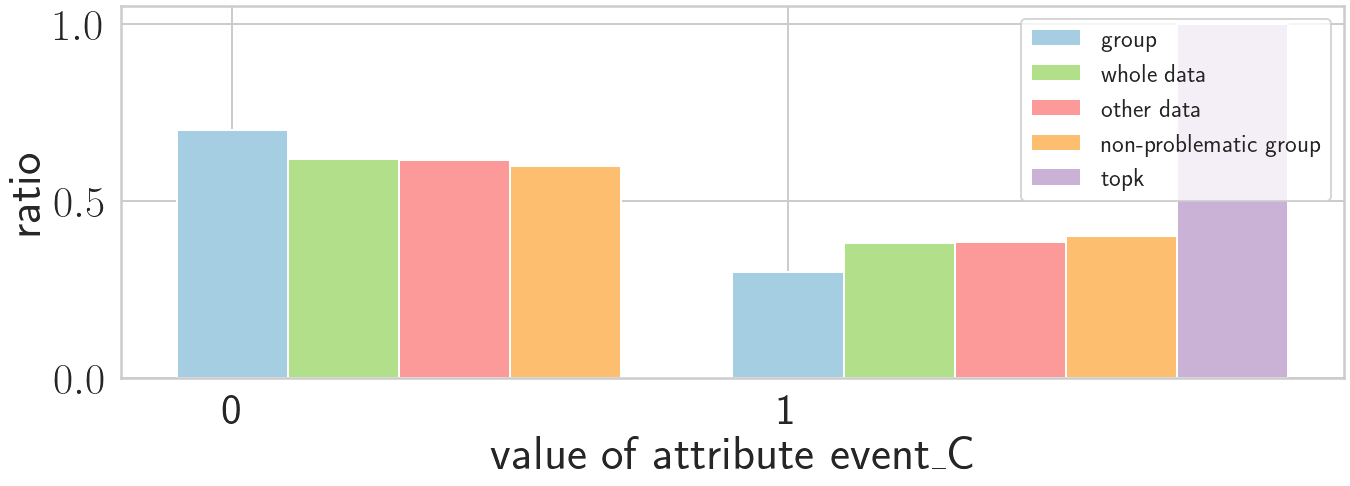

In [50]:
another_group = [-1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
print(check_another_group_prop_bounds(another_group, ranked_data, selected_attributes, thc, alpha, k))

for att in all_attributes:
    plot_distribution_ratio(ranked_data, att, groups_prop_bounds[1], another_group, k)